## PINN fit of the Kuramoto-Sivashinsky Equation

In [1]:
# Import packages and define functions
import tensorflow as tf
import numpy as np
from tensorflow import keras
from get_gradient import get_gradient
from init_NN import initialize_NN, xavier_init

def neural_net(x, t, weights, biases):    
    num_layers = len(weights) + 1
    x = 2.0*(x - np.min(x))/(np.max(x) - np.min(x)) - 1
    t = 2.0*(t - np.min(t))/(np.max(t) - np.min(x)) - 1
    H = tf.concat([x, t], axis=1)        
    for l in range(0,num_layers-2):
        W = weights[l]
        b = biases[l]
        H = tf.tanh(H @ W + b)
    W = weights[-1]
    b = biases[-1]
    Y = H @ W + b
    return Y

def net_f(x, t, weights, biases):
    u = neural_net(x, t, weights, biases)
    nn_x = lambda y: neural_net(y, t, weights, biases) # suppress dependence on weights, biases, & other variable
    nn_t = lambda y: neural_net(x, y, weights, biases)
    u_t = get_gradient(t, nn_t)
    u_x = get_gradient(x, nn_x)    
    # u_xxx = get_gradient(x, lambda y2: get_gradient(y2, lambda y1: get_gradient(y1, nn_x)))    
    u_xx = get_gradient(x, lambda y: get_gradient(y, nn_x))
    u_xxxx = get_gradient(x, lambda y3: get_gradient(y3, lambda y2: get_gradient(y2, lambda y1: get_gradient(y1, nn_x))))
    f = u_t + u*u_x + u_xx + u_xxxx # Governing eqn
    return f, u, u_t, u_x, u_xx, u_xxxx

def loss_function(u_obs, x_obs, t_obs, x_f, t_f, weights, biases):
    u = neural_net(x_obs, t_obs, weights, biases)
    f, _, _, _, _, _ = net_f(x_f, t_f, weights, biases)
    loss = tf.reduce_mean(tf.square(u - u_obs)) + tf.reduce_mean(tf.square(f))
    return loss

### Begin by loading a solution 
The Kuramoto-Sivashinsky equation 
$$f = \partial_tu + u\partial_xu + \partial^2_xu + \partial^4_xu = 0,$$
has a chaotic solution generated with a spectral solver. This solution is instantiated on the domain $(x,t)\in[0,32\pi]\times[0,250]$ for use as reference data. The initial condition at $t=0$ is discretized and sampled with $N_{IC}=52$ points, and $N_u=100$ points are randomly spaced throughout the spatiotemporal domain. Furthermore, the loss function is constrained to satisfy the governing equation on a denser mesh $N_f=n_x\times n_t=251\times256$

(50, 512)
(512,)


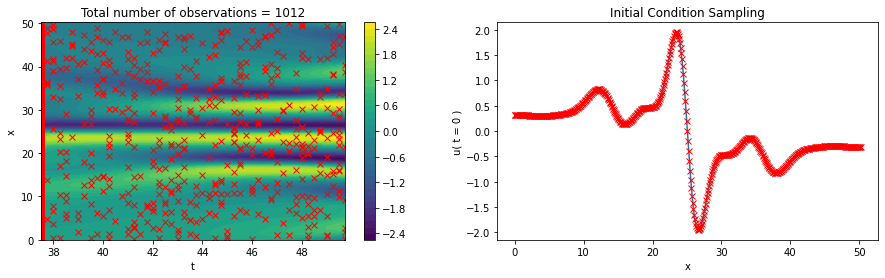

In [2]:
import random
import matplotlib.pyplot as plt
from scipy.special import erf
from scipy.io import loadmat

# Load Data
ks_data = loadmat('KS_1_1.mat')
Nx = int(ks_data['Nx'])
n_ss = 1 # sub-sample number

x_left = 0
x_right = 32*np.pi
x_full = np.linspace(x_left, x_right, Nx)
x_full = x_full[:round(Nx/2):n_ss]
nx = x_full.shape[0]

t_full = ks_data['tt'].reshape(-1)
t_full = t_full[150:200]
t_start = t_full[0]
t_end = t_full[-1]
nt = t_full.shape[0]

[xx, tt] = np.meshgrid(x_full, t_full)
u_full = ks_data['uu'].T
u_full = u_full[150:200,:round(Nx/2):n_ss]
print(u_full.shape)
print(x_full.shape)

# Columnate the matrices
x_ = np.reshape(xx, (nx*nt, 1))
t_ = np.reshape(tt, (nx*nt, 1))
u_ = np.reshape(u_full, (nx*nt, 1))

# Grid locations to enforce governing equations
x_f = x_ 
t_f = t_

# Sampling the IC
t_IC = tt[0,:].reshape(-1,1)
x_IC = xx[0,:].reshape(-1,1)
u_IC = u_full[0,:].reshape(-1,1)

# Sampling the "boundary"
left_cond = x_ == x_left
right_cond = x_ == x_right
t_lb = t_[left_cond, None]
x_lb = x_[left_cond, None]
u_lb = u_[left_cond, None]
t_rb = t_[right_cond, None]
x_rb = x_[right_cond, None]
u_rb = u_[right_cond, None]

# Random sampling in the bulk
N = 500
samples = random.sample(list(range(nx*nt)), N)
x_smp = x_[samples] # bulk sampling
t_smp = t_[samples]
u_smp = u_[samples]

# Grid locations to fit the observed data
x_obs = np.concatenate([x_IC, x_smp], axis=0)
t_obs = np.concatenate([t_IC, t_smp], axis=0)
u_obs = np.concatenate([u_IC, u_smp], axis=0)

# Plot full sampling
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
cntrf = ax[0].contourf(tt, xx, u_full, levels=40)
ax[0].plot(t_obs, x_obs, 'rx')
ax[0].set(xlabel='t', ylabel='x', title='Total number of observations = ' + str(len(x_obs)))
plt.colorbar(cntrf, ax=ax[0])

# Plot IC sampling
ax[1].plot(x_full, u_full[0,:])
ax[1].plot(x_IC, u_IC, 'rx')
ax[1].set(xlabel='x', ylabel='u( t = 0 )', title='Initial Condition Sampling')
plt.show()

### Train the Neural Network
The (physics informed) neural network's weights & biases are Xavier-initialized for 4 hidden layers, each with 50 neurons and hyperbolic tangent activation functions. The network parameters are trained using the built-in Keras Adam optimizer with a learning rate of 0.01 for 1000 epochs.

In [ ]:
# Initialize Neural Network
layers = [2, 100, 100, 100, 1]
weights, biases = initialize_NN(layers)

# Make sure data is a tensor
x_obs = tf.constant(x_obs, dtype=tf.float32)
t_obs = tf.constant(t_obs, dtype=tf.float32)
x_f = tf.constant(x_f, dtype=tf.float32)
t_f = tf.constant(t_f, dtype=tf.float32)

# Train the model
opt = keras.optimizers.Adam(learning_rate=0.01)
N_epochs = 1000
loss = np.zeros(N_epochs+1)
loss[0] = loss_function(u_obs, x_obs, t_obs, x_f, t_f, weights, biases)
for j in range(N_epochs):
    if j % 100 == 0:
        print('Iteration ' + str(j))    
    opt.minimize(lambda: loss_function(u_obs, x_obs, t_obs, x_f, t_f, weights, biases), var_list=[weights, biases])        
    loss[j+1] = loss_function(u_obs, x_obs, t_obs, x_f, t_f, weights, biases)

# Print the loss as a function of epoch
plt.plot(loss)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Results
The solution is learned remarkably well; in particular, the PINN can recreate a snapshot at $t=5$ indistinguishably from the truth. It is worth emphasizing that no discretization scheme (for e.g. time-integration) needed to be specified, and the training data in the bulk was on a very irregular mesh. The residual has noticable disagreements, but it could be decreased further by (a) training longer or (b) enforcing the governing equation on a higher-resolution grid.

In [ ]:
# Get a full domain prediction
u_pred = neural_net(x_f, t_f, weights, biases).numpy()
U_pred = np.reshape(u_pred, (nt, nx))

# Compare the contours
cmp_ind = 40
fig, axs = plt.subplots(1, 3, figsize=(18,4))
cntr_true = axs[0].contourf(tt, xx, u_full, levels=40)
axs[0].plot([t_full[cmp_ind], t_full[cmp_ind]], [x_full[0], x_full[-1]], 'r--')
axs[0].set(xlabel='t', ylabel='x', title='Truth')
cntr_pred = axs[1].contourf(tt, xx, U_pred, levels=40)
axs[1].plot([t_full[cmp_ind], t_full[cmp_ind]], [x_full[0], x_full[-1]], 'r--')
axs[1].set(xlabel='t', ylabel='x', title='Fit')
plt.colorbar(cntr_true, ax=axs[0])
plt.colorbar(cntr_pred, ax=axs[1])
axs[2].plot(x_full, u_full[cmp_ind,:], 'k', label='Truth')
axs[2].plot(x_full, U_pred[cmp_ind,:], 'r--', label='Fit')
axs[2].legend()
axs[2].set(xlabel='x', ylabel='u', title='Fit at t = ' + str(t_full[cmp_ind]))
plt.show()

In [ ]:
# Plot the residual & governing equation components
f, u, u_t, u_x, u_xx, u_xxxx = net_f(x_f, t_f, weights, biases)

fig, ax = plt.subplots(1, 5, figsize=(18, 4))

cntr_f = ax[1].contourf(tt, xx, f.numpy().reshape(nt, nx), levels=40)
plt.colorbar(cntr_f, ax=ax[1])
ax[1].set(xlabel='t', ylabel='x', title='f')

cntr_t = ax[2].contourf(tt, xx, u_t.numpy().reshape(nt, nx), levels=40)
plt.colorbar(cntr_t, ax=ax[2])
ax[2].set(xlabel='t', ylabel='x', title='u_t')

cntr_x = ax[3].contourf(tt, xx, u_x.numpy().reshape(nt, nx), levels=40)
plt.colorbar(cntr_x, ax=ax[3])
ax[3].set(xlabel='t', ylabel='x', title='u_x')

cntr_xx = ax[4].contourf(tt, xx, u_xx.numpy().reshape(nt, nx), levels=40)
plt.colorbar(cntr_xx, ax=ax[4])
ax[4].set(xlabel='t', ylabel='x', title='u_xx')

cntr_xxxx = ax[0].contourf(tt, xx, u_xxxx.numpy().reshape(nt, nx), levels=40)
plt.colorbar(cntr_f, ax=ax[0])
ax[0].set(xlabel='t', ylabel='x', title='u_xxxx')
plt.show()

In [ ]:
a = 57
b = 108
x = np.linspace(a, b, 150)
y = 2/(np.max(x) - np.min(x))*(x - np.min(x)) - 1

print(np.max(x), np.min(x))
print(x[0], x[-1])
plt.plot(x, y)
plt.show()